# Task 2-Experimentation and Uplift testing

Julia has asked us to evaluate the performance of a store trial which was performed in stores 77, 86 and 88.

This can be broken down by:

1. total sales revenue
2. total number of customers
3. average number of transactions per customer

Create a measure to compare different control stores to each of the trial stores to do this write a function to reduce having to re-do the analysis for each trial store. Consider using Pearson correlations or a metric such as a magnitude distance e.g. 1- (Observed distance – minimum distance)/(Maximum distance – minimum distance) as a measure.

Once you have selected your control stores, compare each trial and control pair during the trial period. You want to test if total sales are significantly different in the trial period and if so, check if the driver of change is more purchasing customers or more purchases per customers etc.

Main areas of Focus are :

1. Select control stores – Explore data, define metrics, visualize graphs
2. Assessment of the trial – insights/trends by comparing trial stores with control stores
3. Collate findings – summarize and provide recommendations


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
     
    

qvi = pd.read_csv("Task1_completed.csv")
qvi.drop('Unnamed: 0', axis=1, inplace=True)
qvi.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget


In [2]:
qvi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246740 entries, 0 to 246739
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   DATE              246740 non-null  object 
 1   STORE_NBR         246740 non-null  int64  
 2   LYLTY_CARD_NBR    246740 non-null  int64  
 3   TXN_ID            246740 non-null  int64  
 4   PROD_NBR          246740 non-null  int64  
 5   PROD_NAME         246740 non-null  object 
 6   PROD_QTY          246740 non-null  int64  
 7   TOT_SALES         246740 non-null  float64
 8   PACK_SIZE         246740 non-null  int64  
 9   BRAND             246740 non-null  object 
 10  LIFESTAGE         246740 non-null  object 
 11  PREMIUM_CUSTOMER  246740 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 22.6+ MB


In [3]:
qvi["DATE"] = pd.to_datetime(qvi["DATE"])
qvi["YEARMONTH"] = qvi["DATE"].dt.strftime("%Y%m").astype("int")

Compile each store's monthly:

1. Total sales
2. Number of customers,
3. Average transactions per customer
4. Average chips per customer
5. Average price per unit

In [4]:
def monthly_store_metrics():
    store_yrmo_group = qvi.groupby(["STORE_NBR", "YEARMONTH"])
    total = store_yrmo_group["TOT_SALES"].sum()
    num_cust = store_yrmo_group["LYLTY_CARD_NBR"].nunique()
    trans_per_cust = store_yrmo_group.size() / num_cust
    avg_chips_per_cust = store_yrmo_group["PROD_QTY"].sum() / num_cust
    avg_chips_price = total / store_yrmo_group["PROD_QTY"].sum()
    aggregates = [total, num_cust, trans_per_cust, avg_chips_per_cust, avg_chips_price]
    metrics = pd.concat(aggregates, axis=1)
    metrics.columns = ["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"]
    return metrics

In [5]:
qvi_monthly_metrics = monthly_store_metrics().reset_index()
qvi_monthly_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3165 entries, 0 to 3164
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STORE_NBR        3165 non-null   int64  
 1   YEARMONTH        3165 non-null   int64  
 2   TOT_SALES        3165 non-null   float64
 3   nCustomers       3165 non-null   int64  
 4   nTxnPerCust      3165 non-null   float64
 5   nChipsPerTxn     3165 non-null   float64
 6   avgPricePerUnit  3165 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 173.2 KB


### Pre-Trial Observation as this filter only stores with full 12 months observation

In [6]:
observ_counts = qvi_monthly_metrics["STORE_NBR"].value_counts()
full_observ_index = observ_counts[observ_counts == 12].index
full_observ = qvi_monthly_metrics[qvi_monthly_metrics["STORE_NBR"].isin(full_observ_index)]
pretrial_full_observ = full_observ[full_observ["YEARMONTH"] < 201902]

pretrial_full_observ.head(8)

,STORE_NBR,YEARMONTH,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,188.9,47,1.042553,1.234043,3.256897
1,1,201808,168.4,41,1.000000,1.268293,3.238462
2,1,201809,268.1,57,1.035088,1.245614,3.776056
3,1,201810,175.4,39,1.025641,1.307692,3.439216
4,1,201811,184.8,44,1.022727,1.250000,3.360000
5,1,201812,160.6,37,1.081081,1.297297,3.345833
6,1,201901,149.7,35,1.000000,1.171429,3.651220
12,2,201807,140.5,36,1.055556,1.194444,3.267442


In [10]:
def calcCorrTable(metricCol, storeComparison, inputTable=pretrial_full_observ):
  control_store_nbrs = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
  corrs = pd.DataFrame(columns = ["YEARMONTH", "Trial_Str", "Ctrl_Str", "Corr_Score"])
  trial_store = inputTable[inputTable["STORE_NBR"] == storeComparison][metricCol].reset_index()
  for control in control_store_nbrs:
    concat_df = pd.DataFrame(columns = ["YEARMONTH", "Trial_Str", "Ctrl_Str", "Corr_Score"])
    control_store = inputTable[inputTable["STORE_NBR"] == control][metricCol].reset_index()
    concat_df["Corr_Score"] = trial_store.corrwith(control_store, axis=1)
    concat_df["Trial_Str"] = storeComparison
    concat_df["Ctrl_Str"] = control
    concat_df["YEARMONTH"] = list(inputTable[inputTable["STORE_NBR"] == storeComparison]["YEARMONTH"])
    corrs = pd.concat([corrs, concat_df])
  return corrs

In [11]:
corr_table = pd.DataFrame()
for trial_num in [77, 86, 88]:
    corr_table = pd.concat([corr_table, calcCorrTable(["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"], trial_num)])
    
corr_table.head(10)

,YEARMONTH,Trial_Str,Ctrl_Str,Corr_Score
0,201807,77,1,0.034928
1,201808,77,1,0.017017
2,201809,77,1,-0.007445
3,201810,77,1,-0.028881
4,201811,77,1,0.007549
5,201812,77,1,0.051580
6,201901,77,1,-0.017382
0,201807,77,2,0.116765
1,201808,77,2,0.094303
2,201809,77,2,0.080021


In [13]:
def calculateMagnitudeDistance(metricCol, storeComparison, inputTable=pretrial_full_observ):
    control_store_nbrs = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
    dists = pd.DataFrame()
    trial_store = inputTable[inputTable["STORE_NBR"] == storeComparison][metricCol]
    for control in control_store_nbrs:
        concat_df  = abs(inputTable[inputTable["STORE_NBR"] == storeComparison].reset_index()[metricCol] - inputTable[inputTable["STORE_NBR"] == control].reset_index()[metricCol])
        concat_df["YEARMONTH"] = list(inputTable[inputTable["STORE_NBR"] == storeComparison]["YEARMONTH"])
        concat_df["Trial_Str"] = storeComparison
        concat_df["Ctrl_Str"] = control
        dists = pd.concat([dists, concat_df])
    for col in metricCol:
        dists[col] = 1 - ((dists[col] - dists[col].min()) / (dists[col].max() - dists[col].min()))
    dists["magnitude"] = dists[metricCol].mean(axis=1)
    return dists

In [14]:
dist_table = pd.DataFrame()
for trial_num in [77, 86, 88]:
    dist_table = pd.concat([dist_table, calculateMagnitudeDistance(["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"], trial_num)])
    
dist_table.head(8)
dist_table

,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,YEARMONTH,Trial_Str,Ctrl_Str,magnitude
0,0.939141,1.000000,0.906165,0.716452,0.853885,201807,77,1,0.883128
1,0.939447,0.950495,1.000000,0.807168,0.841984,201808,77,1,0.907819
2,0.960729,0.831683,0.967117,0.716360,0.686332,201809,77,1,0.832444
3,0.985532,0.970297,0.995288,0.943513,0.714699,201810,77,1,0.921866
4,0.969303,0.950495,0.880491,0.743772,0.866003,201811,77,1,0.882013
...,...,...,...,...,...,...,...,...,...
2,0.209407,0.268293,0.613056,0.797921,0.923369,201809,88,272,0.562409
3,0.358741,0.357724,0.773519,0.861789,0.969082,201810,88,272,0.664171
4,0.292148,0.317073,0.665863,0.792787,0.964449,201811,88,272,0.606464
5,0.370444,0.373984,0.571429,0.722481,0.963101,201812,88,272,0.600288


We'll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores by using correlation and magnitude distance.

In [15]:
def combine_corr_dist(metricCol, storeComparison, inputTable=pretrial_full_observ):
    corrs = calcCorrTable(metricCol, storeComparison, inputTable)
    dists = calculateMagnitudeDistance(metricCol, storeComparison, inputTable)
    dists = dists.drop(metricCol, axis=1)
    combine = pd.merge(corrs, dists, on=["YEARMONTH", "Trial_Str", "Ctrl_Str"])
    return combine

In [16]:
compare_metrics_table1 = pd.DataFrame()
for trial_num in [77, 86, 88]:
    compare_metrics_table1 = pd.concat([compare_metrics_table1, combine_corr_dist(["TOT_SALES"], trial_num)])

In [17]:
corr_weight = 0.5
dist_weight = 1 - corr_weight

Determining the top five highest composite score for each trial based on Total sales

In [20]:
grouped_comparison_table1 = compare_metrics_table1.groupby(["Trial_Str", "Ctrl_Str"]).mean().reset_index()
grouped_comparison_table1["CompScore"] = (corr_weight * grouped_comparison_table1["Corr_Score"]) + (dist_weight * grouped_comparison_table1["magnitude"])
for trial_num in compare_metrics_table1["Trial_Str"].unique():
    print(grouped_comparison_table1[grouped_comparison_table1["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").head(), '\n')

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
217         77       233         1.0   0.986702   0.993351
176         77       188         1.0   0.980567   0.990283
120         77       131         1.0   0.977341   0.988670
238         77       255         1.0   0.976794   0.988397
192         77       205         1.0   0.976706   0.988353 

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
400         86       155         1.0   0.964165   0.982082
355         86       109         1.0   0.955015   0.977507
383         86       138         1.0   0.950843   0.975421
362         86       116         1.0   0.950053   0.975027
449         86       207         1.0   0.949940   0.974970 

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
549         88        40         1.0   0.933101   0.966550
515         88         4         1.0   0.911153   0.955577
536         88        26         1.0   0.907058   0.953529
566         88        58         1.0   0.893688   0.

In [23]:
compare_metrics_table2 = pd.DataFrame()
for trial_num in [77, 86, 88]:
    compare_metrics_table2 = pd.concat([compare_metrics_table2, combine_corr_dist(["nCustomers"], trial_num)])

Determining the top five highest composite score for each trial based on no. of customers

In [24]:
grouped_comparison_table2 = compare_metrics_table2.groupby(["Trial_Str", "Ctrl_Str"]).mean().reset_index()
grouped_comparison_table2["CompScore"] = (corr_weight * grouped_comparison_table2["Corr_Score"]) + (dist_weight * grouped_comparison_table2["magnitude"])
for trial_num in compare_metrics_table2["Trial_Str"].unique():
    print(grouped_comparison_table2[grouped_comparison_table2["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").head(), '\n')

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
217         77       233         1.0   0.991513   0.995757
38          77        41         1.0   0.961810   0.980905
15          77        17         1.0   0.960396   0.980198
42          77        46         1.0   0.960396   0.980198
134         77       145         1.0   0.957567   0.978784 

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
400         86       155         1.0   0.975035   0.987517
465         86       225         1.0   0.968100   0.984050
360         86       114         1.0   0.959778   0.979889
355         86       109         1.0   0.951456   0.975728
428         86       184         1.0   0.951456   0.975728 

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
733         88       237         1.0   0.979094   0.989547
549         88        40         1.0   0.939605   0.969803
698         88       199         1.0   0.938444   0.969222
666         88       165         1.0   0.931475   0.

In [25]:
for trial_num in compare_metrics_table2["Trial_Str"].unique():
    a = grouped_comparison_table1[grouped_comparison_table1["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").set_index(["Trial_Str", "Ctrl_Str"])["CompScore"]
    b = grouped_comparison_table2[grouped_comparison_table2["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").set_index(["Trial_Str", "Ctrl_Str"])["CompScore"]
    print((pd.concat([a,b], axis=1).sum(axis=1)/2).sort_values(ascending=False).head(3), '\n')

Trial_Str  Ctrl_Str
77         233         0.994554
           46          0.983852
           188         0.981705
dtype: float64 

Trial_Str  Ctrl_Str
86         155         0.984800
           109         0.976618
           225         0.975346
dtype: float64 

Trial_Str  Ctrl_Str
88         40          0.968176
           26          0.957020
           58          0.953097
dtype: float64 



Similarities based on total sales:
1. Trial store 77: Store 233, 255, 188
2. Trial store 86: Store 109, 155, 222
3. Trial store 88: Store 40, 26, 72

Similarities based on No. of Customers:
1. Trial store 77: Store 233, 41, 111
2. Trial store 86: Store 155, 225, 109
3. Trial store 88: Store 237, 203, 40

Final SImilarities based on Highest average of both features combined:
1. Trial store 77: Store 233
2. Trial store 86: Store 155
3. Trial store 88: Store 40

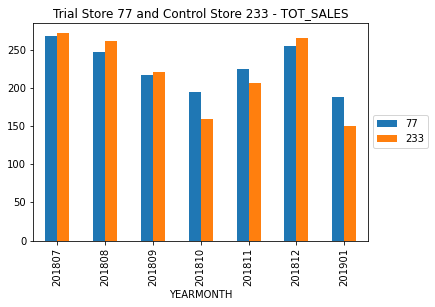

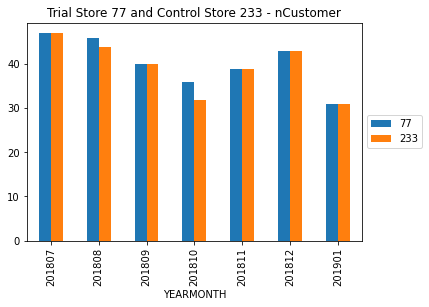

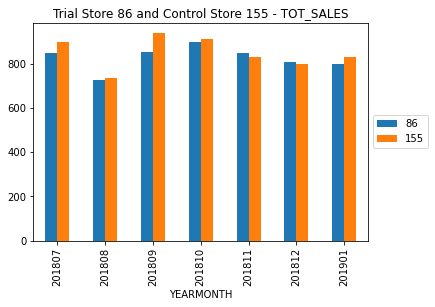

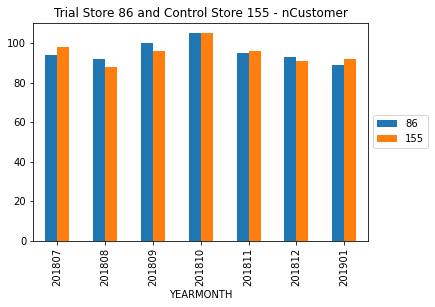

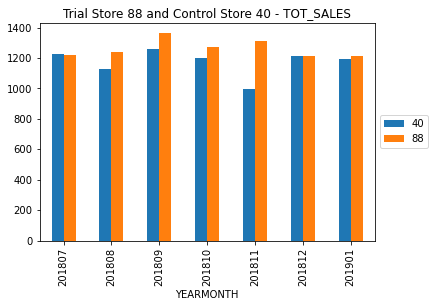

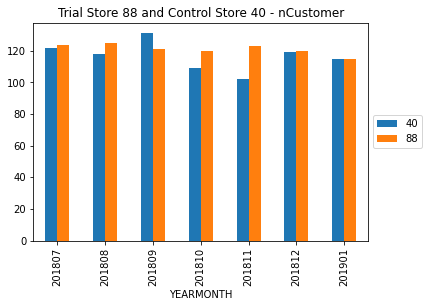

In [26]:
trial_control_dic = {77:233, 86:155, 88:40}
for key, val in trial_control_dic.items():
    pretrial_full_observ[pretrial_full_observ["STORE_NBR"].isin([key, val])].groupby(
        ["YEARMONTH", "STORE_NBR"]).sum()["TOT_SALES"].unstack().plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(key)+" and Control Store "+str(val)+" - TOT_SALES")
    plt.show()
    pretrial_full_observ[pretrial_full_observ["STORE_NBR"].isin([key, val])].groupby(
    ["YEARMONTH", "STORE_NBR"]).sum()["nCustomers"].unstack().plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(key)+" and Control Store "+str(val)+" - nCustomer")
    plt.show()
    print('\n')

Next we'll compare the performance of Trial stores to Control stores during the trial period. To ensure their performance is comparable during Trial period, we need to scale (multiply to ratio of trial / control) all of Control stores' performance to Trial store's performance during pre-trial. Starting with TOT_SALES.

In [27]:
#Ratio of Store 77 and its Control store.
sales_ratio_77 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 77]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 233]["TOT_SALES"].sum()

#Ratio of Store 86 and its Control store.
sales_ratio_86 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 86]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 155]["TOT_SALES"].sum()

#Ratio of Store 77 and its Control store.
sales_ratio_88 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 88]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 40]["TOT_SALES"].sum()

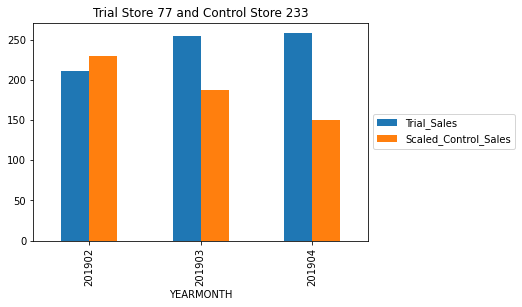

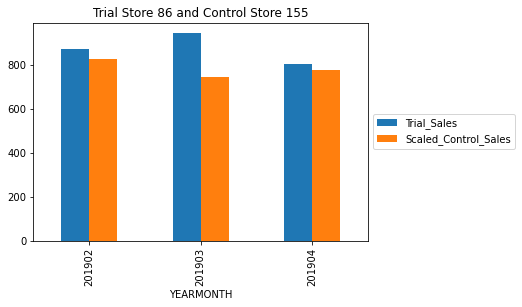

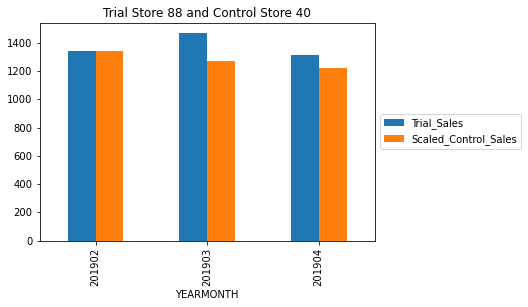

In [28]:
trial_full_observ = full_observ[(full_observ["YEARMONTH"] >= 201902) & (full_observ["YEARMONTH"] <= 201904)]
scaled_sales_control_stores = full_observ[full_observ["STORE_NBR"].isin([233, 155, 40])][["STORE_NBR", "YEARMONTH", "TOT_SALES"]]

def scaler(row):
    if row["STORE_NBR"] == 233:
        return row["TOT_SALES"] * sales_ratio_77
    elif row["STORE_NBR"] == 155:
        return row["TOT_SALES"] * sales_ratio_86
    elif row["STORE_NBR"] == 40:
        return row["TOT_SALES"] * sales_ratio_88

scaled_sales_control_stores["ScaledSales"] = scaled_sales_control_stores.apply(lambda row: scaler(row), axis=1)

trial_scaled_sales_control_stores = scaled_sales_control_stores[(scaled_sales_control_stores["YEARMONTH"] >= 201902) & (scaled_sales_control_stores["YEARMONTH"] <= 201904)]
pretrial_scaled_sales_control_stores = scaled_sales_control_stores[scaled_sales_control_stores["YEARMONTH"] < 201902]

percentage_diff = {}

for trial, control in trial_control_dic.items():
    a = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control]
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "TOT_SALES"]]
    percentage_diff[trial] = b["TOT_SALES"].sum() / a["ScaledSales"].sum()
    b[["YEARMONTH", "TOT_SALES"]].merge(a[["YEARMONTH", "ScaledSales"]],on="YEARMONTH").set_index("YEARMONTH").rename(columns={"ScaledSales":"Scaled_Control_Sales", "TOT_SALES":"Trial_Sales"}).plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control))

In [29]:
percentage_diff

{77: 1.2778901246373204, 86: 1.1155403148404528, 88: 1.0736785754013871}

In [30]:
temp1 = scaled_sales_control_stores.sort_values(by=["STORE_NBR", "YEARMONTH"], ascending=[False, True]).reset_index().drop(["TOT_SALES", "index"], axis=1)
temp2 = full_observ[full_observ["STORE_NBR"].isin([77,86,88])][["STORE_NBR", "YEARMONTH", "TOT_SALES"]].reset_index().drop(["index", "YEARMONTH"], axis=1)
scaledsales_vs_trial = pd.concat([temp1, temp2], axis=1)
scaledsales_vs_trial.columns = ["c_STORE_NBR", "YEARMONTH", "c_ScaledSales", "t_STORE_NBR", "t_TOT_SALES"]
scaledsales_vs_trial["Sales_Percentage_Diff"] = (scaledsales_vs_trial["t_TOT_SALES"] - scaledsales_vs_trial["c_ScaledSales"]) / (((scaledsales_vs_trial["t_TOT_SALES"] + scaledsales_vs_trial["c_ScaledSales"])/2))
def label_period(cell):
    if cell < 201902:
        return "pre"
    elif cell > 201904:
        return "post"
    else:
        return "trial"
scaledsales_vs_trial["trial_period"] = scaledsales_vs_trial["YEARMONTH"].apply(lambda cell: label_period(cell))
scaledsales_vs_trial[scaledsales_vs_trial["trial_period"] == "trial"]

,c_STORE_NBR,YEARMONTH,c_ScaledSales,t_STORE_NBR,t_TOT_SALES,Sales_Percentage_Diff,trial_period
7,233,201902,229.473346,77,211.6,-0.081045,trial
8,233,201903,187.779277,77,255.1,0.304014,trial
9,233,201904,149.932291,77,258.1,0.530192,trial
19,155,201902,827.019610,86,872.8,0.053865,trial
20,155,201903,745.561872,86,945.4,0.236360,trial
21,155,201904,778.028321,86,804.0,0.032833,trial
31,40,201902,1346.153002,88,1339.6,-0.004880,trial
32,40,201903,1273.550526,88,1467.0,0.141176,trial
33,40,201904,1220.924472,88,1317.0,0.075712,trial


Check significance of Trial minus Control stores TOT_SALES Percentage Difference Pre-Trial vs Trial.

Step 1: Check null hypothesis of 0 difference between control store's Pre-Trial and Trial period performance.

Step 2: Proof control and trial stores are similar statistically

Check p-value of control store's Pre-Trial vs Trial store's Pre-Trial.
If <5%, it is significantly different. If >5%, it is not significantly different (similar).

Step 3: After checking Null Hypothesis of first 2 step to be true, we can check Null Hypothesis of Percentage Difference between Trial and Control stores during pre-trial is the same as during trial.

Check T-Value of Percentage Difference of each Trial month (Feb, March, April 2019).
Mean is mean of Percentage Difference during pre-trial.
Standard deviation is stdev of Percentage Difference during pre-trial.
Formula is Trial month's Percentage Difference minus Mean, divided by Standard deviation.
Compare each T-Value with 95% percentage significance critical t-value of 6 degrees of freedom (7 months of sample - 1)

In [31]:
from scipy.stats import ttest_ind, t

# Step 1
for num in [40, 155, 233]:
    print("Store", num)
    print(ttest_ind(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"],
                   trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"],
                   equal_var=False), '\n')
    #print(len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"]), len(trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"]))
    
alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=min([len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == num]),
                       len(trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == num])])-1))

Store 40
Ttest_indResult(statistic=-0.36013226673707055, pvalue=0.7312292961250695) 

Store 155
Ttest_indResult(statistic=1.2632008050177177, pvalue=0.24959862186836165) 

Store 233
Ttest_indResult(statistic=1.2851941918470577, pvalue=0.2540387701484951) 

Critical t-value for 95% confidence interval:
[-4.30265273  4.30265273]


In [32]:
a = pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == 40]["ScaledSales"]
b = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == 40]["ScaledSales"]

Null hypothesis is true. There isn't any statistically significant difference between control store's scaled Pre-Trial and Trial period sales.

In [33]:
# Step 2
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    print(ttest_ind(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial]["TOT_SALES"],
                   pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == cont]["ScaledSales"],
                   equal_var=True), '\n')
    #print(len(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial]["TOT_SALES"]),len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == cont]["ScaledSales"]))

alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=len(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial])-1))

Trial store: 77 , Control store: 233
Ttest_indResult(statistic=2.4926005499695936e-15, pvalue=0.999999999999998) 

Trial store: 86 , Control store: 155
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Trial store: 88 , Control store: 40
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Critical t-value for 95% confidence interval:
[-2.44691185  2.44691185]


Null hypothesis is true. There isn't any statistically significant difference between Trial store's sales and Control store's scaled-sales performance during pre-trial.

In [34]:
# Step 3
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    temp_pre = scaledsales_vs_trial[(scaledsales_vs_trial["c_STORE_NBR"] == cont) & (scaledsales_vs_trial["trial_period"]=="pre")]
    std = temp_pre["Sales_Percentage_Diff"].std()
    mean = temp_pre["Sales_Percentage_Diff"].mean()
    #print(std, mean)
    for t_month in scaledsales_vs_trial[scaledsales_vs_trial["trial_period"] == "trial"]["YEARMONTH"].unique():
        pdif = scaledsales_vs_trial[(scaledsales_vs_trial["YEARMONTH"] == t_month) & (scaledsales_vs_trial["t_STORE_NBR"] == trial)]["Sales_Percentage_Diff"]
        print(t_month,":",(float(pdif)-mean)/std)
    print('\n')
    
print("Critical t-value for 95% confidence interval:")
conf_intv_95 = t.ppf(0.95, df=len(temp_pre)-1)
print(conf_intv_95)

Trial store: 77 , Control store: 233
201902 : -0.8435806220494315
201903 : 2.4904464734755805
201904 : 4.448806995302806


Trial store: 86 , Control store: 155
201902 : 1.3077596199049661
201903 : 5.828582596615282
201904 : 0.7867590051021528


Trial store: 88 , Control store: 40
201902 : -0.06747939544188036
201903 : 1.4413280336576249
201904 : 0.7650631287827934


Critical t-value for 95% confidence interval:
1.9431802803927816


There are 3 months' increase in performance that are statistically significant (Above the 95% confidence interval t-score):

March and April trial months for trial store 77

March trial months for trial store 86

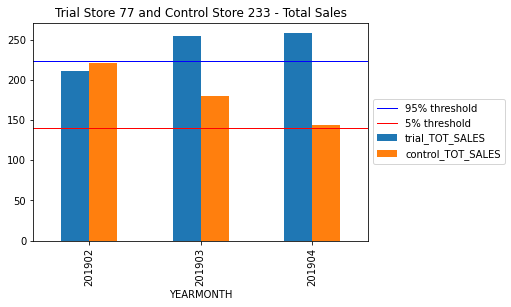

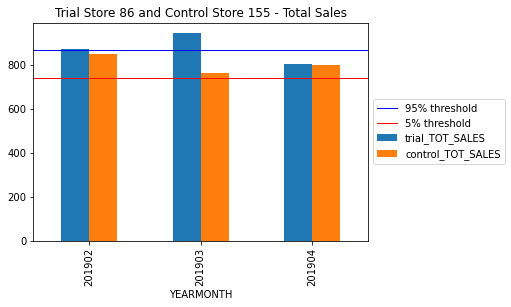

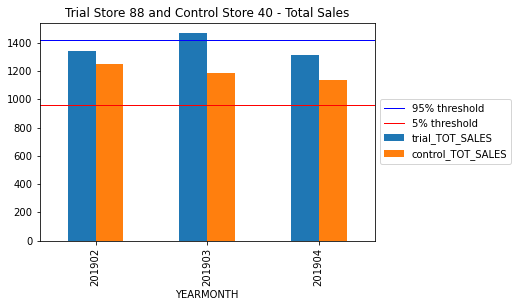

In [35]:
for trial, control in trial_control_dic.items():
    a = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control].rename(columns={"TOT_SALES": "control_TOT_SALES"})
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "TOT_SALES"]].rename(columns={"TOT_SALES": "trial_TOT_SALES"})
    comb = b[["YEARMONTH", "trial_TOT_SALES"]].merge(a[["YEARMONTH", "control_TOT_SALES"]],on="YEARMONTH").set_index("YEARMONTH")
    comb.plot.bar()
    cont_sc_sales = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control]["TOT_SALES"]
    std = scaledsales_vs_trial[(scaledsales_vs_trial["c_STORE_NBR"] == control) & (scaledsales_vs_trial["trial_period"]=="pre")]["Sales_Percentage_Diff"].std()
    thresh95 = cont_sc_sales.mean() + (cont_sc_sales.mean() * std * 2)
    thresh5 = cont_sc_sales.mean() - (cont_sc_sales.mean() * std * 2)
    plt.axhline(y=thresh95,linewidth=1, color='b', label="95% threshold")
    plt.axhline(y=thresh5,linewidth=1, color='r', label="5% threshold")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control)+" - Total Sales")
    plt.savefig("TS {} and CS {} - TOT_SALES.png".format(trial,control), bbox_inches="tight")

In [36]:
#Ratio of Store 77 and its Control store.
ncust_ratio_77 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 77]["nCustomers"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 233]["nCustomers"].sum()

#Ratio of Store 86 and its Control store.
ncust_ratio_86 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 86]["nCustomers"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 155]["nCustomers"].sum()

#Ratio of Store 77 and its Control store.
ncust_ratio_88 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 88]["nCustomers"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 40]["nCustomers"].sum()

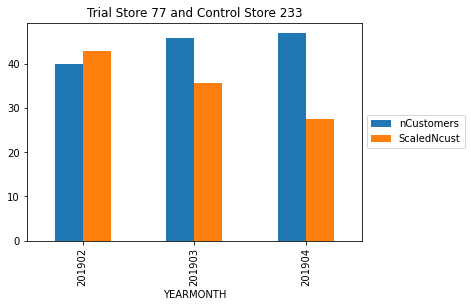

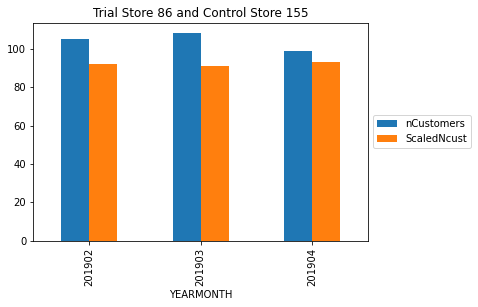

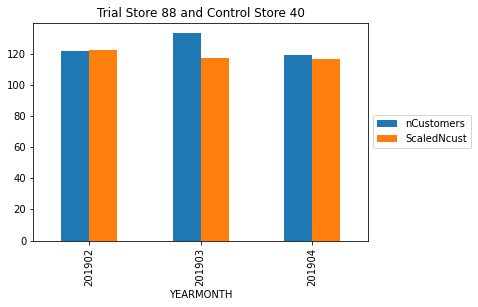

In [37]:
#trial_full_observ = full_observ[(full_observ["YEARMONTH"] >= 201902) & (full_observ["YEARMONTH"] <= 201904)]
scaled_ncust_control_stores = full_observ[full_observ["STORE_NBR"].isin([233, 155, 40])][["STORE_NBR", "YEARMONTH", "nCustomers"]]

def scaler_c(row):
    if row["STORE_NBR"] == 233:
        return row["nCustomers"] * ncust_ratio_77
    elif row["STORE_NBR"] == 155:
        return row["nCustomers"] * ncust_ratio_86
    elif row["STORE_NBR"] == 40:
        return row["nCustomers"] * ncust_ratio_88

scaled_ncust_control_stores["ScaledNcust"] = scaled_ncust_control_stores.apply(lambda row: scaler_c(row), axis=1)

trial_scaled_ncust_control_stores = scaled_ncust_control_stores[(scaled_ncust_control_stores["YEARMONTH"] >= 201902) & (scaled_ncust_control_stores["YEARMONTH"] <= 201904)]
pretrial_scaled_ncust_control_stores = scaled_ncust_control_stores[scaled_ncust_control_stores["YEARMONTH"] < 201902]

ncust_percentage_diff = {}

for trial, control in trial_control_dic.items():
    a = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control]
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "nCustomers"]]
    ncust_percentage_diff[trial] = b["nCustomers"].sum() / a["ScaledNcust"].sum()
    b[["YEARMONTH", "nCustomers"]].merge(a[["YEARMONTH", "ScaledNcust"]],on="YEARMONTH").set_index("YEARMONTH").rename(columns={"ScaledSales":"Scaled_Control_nCust", "TOT_SALES":"Trial_nCust"}).plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control))

In [38]:
ncust_percentage_diff

{77: 1.2516366612111292, 86: 1.1270502473314241, 88: 1.0492326310578137}

In [39]:
temp1 = scaled_ncust_control_stores.sort_values(by=["STORE_NBR", "YEARMONTH"], ascending=[False, True]).reset_index().drop(["nCustomers", "index"], axis=1)
temp2 = full_observ[full_observ["STORE_NBR"].isin([77,86,88])][["STORE_NBR", "YEARMONTH", "nCustomers"]].reset_index().drop(["index", "YEARMONTH"], axis=1)
scaledncust_vs_trial = pd.concat([temp1, temp2], axis=1)
scaledncust_vs_trial.columns = ["c_STORE_NBR", "YEARMONTH", "c_ScaledNcust", "t_STORE_NBR", "t_nCustomers"]
scaledncust_vs_trial["nCust_Percentage_Diff"] = (scaledncust_vs_trial["t_nCustomers"] - scaledncust_vs_trial["c_ScaledNcust"]) / (((scaledncust_vs_trial["t_nCustomers"] + scaledncust_vs_trial["c_ScaledNcust"])/2))

scaledncust_vs_trial["trial_period"] = scaledncust_vs_trial["YEARMONTH"].apply(lambda cell: label_period(cell))
scaledncust_vs_trial[scaledncust_vs_trial["trial_period"] == "trial"]

,c_STORE_NBR,YEARMONTH,c_ScaledNcust,t_STORE_NBR,t_nCustomers,nCust_Percentage_Diff,trial_period
7,233,201902,42.913043,77,40,-0.070267,trial
8,233,201903,35.760870,77,46,0.250465,trial
9,233,201904,27.586957,77,47,0.520548,trial
19,155,201902,92.276276,86,105,0.128994,trial
20,155,201903,91.273273,86,108,0.167877,trial
21,155,201904,93.279279,86,99,0.059504,trial
31,40,201902,122.627451,88,122,-0.005130,trial
32,40,201903,117.431373,88,133,0.124334,trial
33,40,201904,116.392157,88,119,0.022157,trial


Check significance of Trial minus Control stores nCustomers Percentage Difference Pre-Trial vs Trial.

Step 1: Check null hypothesis of 0 difference between control store's Pre-Trial and Trial period performance.

Step 2: Proof control and trial stores are similar statistically

Step 3: After checking Null Hypothesis of first 2 step to be true, we can check Null Hypothesis of Percentage Difference between Trial and Control stores during pre-trial is the same as during trial.

In [40]:
# Step 1
for num in [40, 155, 233]:
    print("Store", num)
    print(ttest_ind(pretrial_scaled_ncust_control_stores[pretrial_scaled_ncust_control_stores["STORE_NBR"] == num]["ScaledNcust"],
                   trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == num]["ScaledNcust"],
                   equal_var=False), '\n')
    
alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=min([len(pretrial_scaled_ncust_control_stores[pretrial_scaled_ncust_control_stores["STORE_NBR"] == num]),
                       len(trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == num])])-1))

Store 40
Ttest_indResult(statistic=0.5635718480314612, pvalue=0.5885700785723794) 

Store 155
Ttest_indResult(statistic=1.4443707614569483, pvalue=0.19292354514578497) 

Store 233
Ttest_indResult(statistic=0.9728013089400613, pvalue=0.39878209711761925) 

Critical t-value for 95% confidence interval:
[-4.30265273  4.30265273]


In [41]:
# Step 2
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    print(ttest_ind(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial]["nCustomers"],
                   pretrial_scaled_ncust_control_stores[pretrial_scaled_ncust_control_stores["STORE_NBR"] == cont]["ScaledNcust"],
                   equal_var=True), '\n')

alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=len(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial])-1))

Trial store: 77 , Control store: 233
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Trial store: 86 , Control store: 155
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Trial store: 88 , Control store: 40
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Critical t-value for 95% confidence interval:
[-2.44691185  2.44691185]


In [42]:
# Step 3
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    temp_pre = scaledncust_vs_trial[(scaledncust_vs_trial["c_STORE_NBR"] == cont) & (scaledncust_vs_trial["trial_period"]=="pre")]
    std = temp_pre["nCust_Percentage_Diff"].std()
    mean = temp_pre["nCust_Percentage_Diff"].mean()
    #print(std, mean)
    for t_month in scaledncust_vs_trial[scaledncust_vs_trial["trial_period"] == "trial"]["YEARMONTH"].unique():
        pdif = scaledncust_vs_trial[(scaledncust_vs_trial["YEARMONTH"] == t_month) & (scaledncust_vs_trial["t_STORE_NBR"] == trial)]["nCust_Percentage_Diff"]
        print(t_month,":",(float(pdif)-mean)/std)
    print('\n')
    
print("Critical t-value for 95% confidence interval:")
conf_intv_95 = t.ppf(0.95, df=len(temp_pre)-1)
print(conf_intv_95)

Trial store: 77 , Control store: 233
201902 : -1.6033778348003613
201903 : 5.5462661353472695
201904 : 11.566838770938542


Trial store: 86 , Control store: 155
201902 : 3.775892411526406
201903 : 4.914998319676522
201904 : 1.7401582372094115


Trial store: 88 , Control store: 40
201902 : -0.08952991281963425
201903 : 1.4499020670055427
201904 : 0.2349371961466534


Critical t-value for 95% confidence interval:
1.9431802803927816


There are 5 months' increase in performance that are statistically significant (Above the 95% confidence interval t-score):

March and April trial months for trial store 77

Feb, March and April trial months for trial store 86

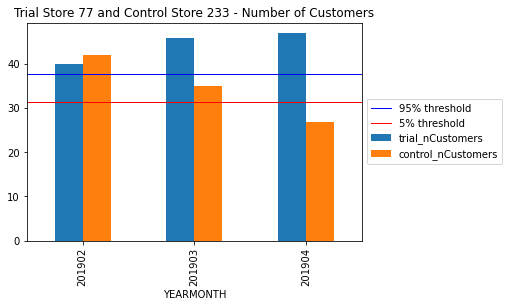

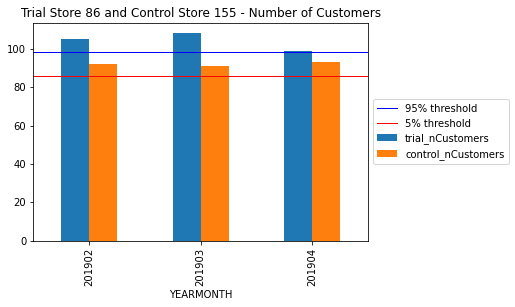

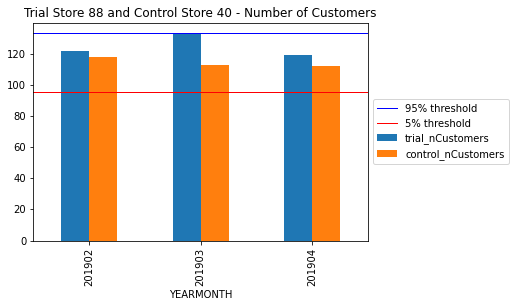

In [43]:
for trial, control in trial_control_dic.items():
    a = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control].rename(columns={"nCustomers": "control_nCustomers"})
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "nCustomers"]].rename(columns={"nCustomers": "trial_nCustomers"})
    comb = b[["YEARMONTH", "trial_nCustomers"]].merge(a[["YEARMONTH", "control_nCustomers"]],on="YEARMONTH").set_index("YEARMONTH")
    comb.plot.bar()
    cont_sc_ncust = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control]["nCustomers"]
    std = scaledncust_vs_trial[(scaledncust_vs_trial["c_STORE_NBR"] == control) & (scaledncust_vs_trial["trial_period"]=="pre")]["nCust_Percentage_Diff"].std()
    thresh95 = cont_sc_ncust.mean() + (cont_sc_ncust.mean() * std * 2)
    thresh5 = cont_sc_ncust.mean() - (cont_sc_ncust.mean() * std * 2)
    plt.axhline(y=thresh95,linewidth=1, color='b', label="95% threshold")
    plt.axhline(y=thresh5,linewidth=1, color='r', label="5% threshold")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control)+" - Number of Customers")
    plt.savefig("TS {} and CS {} - nCustomers.png".format(trial,control), bbox_inches="tight")

We can see that Trial store 77 sales for Feb, March, and April exceeds 95% threshold of control store. Same goes to store 86 sales for all 3 trial months.

1. Trial store 77: Control store 233
2. Trial store 86: Control store 155
3. Trial store 88: Control store 40
4. Both trial store 77 and 86 showed significant increase in Total Sales and Number of Customers during trial period. But not for trial store 88. Perhaps the client knows if there's anything about trial 88 that differs it from the other two trial.
5. Overall the trial showed positive significant result.